# 0. Imports

In [1]:
import json
import pickle
import random
import requests

import numpy             as np
import pandas            as pd
import boruta            as bt
import seaborn           as sns
import xgboost           as xgb
import scikitplot        as skplt
import matplotlib.pyplot as plt

from scipy                import stats
from IPython.core.display import HTML

from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm
from sklearn import preprocessing   as pp
from sklearn import model_selection as ms

## 0.1. Helper Functions

In [2]:
def settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

settings()

def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    return np.sqrt((chi2corr / n) / (min( kcorr-1, rcorr-1)))

def precision_at_k(data, k=2000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[ k, 'precision_at_k'], data)

def recall_at_k(data, k=2000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return (data.loc[ k, 'recall_at_k'], data)

## 0.2. Loading Dataset

In [3]:
df_raw = pd.read_csv('../data/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0000,0,> 2 Years,Yes,40454.0000,26.0000,217,1
1,2,Male,76,1,3.0000,0,1-2 Year,No,33536.0000,26.0000,183,0
2,3,Male,47,1,28.0000,0,> 2 Years,Yes,38294.0000,26.0000,27,1
3,4,Male,21,1,11.0000,1,< 1 Year,No,28619.0000,152.0000,203,0
4,5,Female,29,1,41.0000,1,< 1 Year,No,27496.0000,152.0000,39,0


# 1. Data Description

In [4]:
df_raw.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [5]:
df1 = df_raw.copy()

In [6]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 
            'annual_premium', 'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0000,0,> 2 Years,Yes,40454.0000,26.0000,217,1
1,2,Male,76,1,3.0000,0,1-2 Year,No,33536.0000,26.0000,183,0
2,3,Male,47,1,28.0000,0,> 2 Years,Yes,38294.0000,26.0000,27,1
3,4,Male,21,1,11.0000,1,< 1 Year,No,28619.0000,152.0000,203,0
4,5,Female,29,1,41.0000,1,< 1 Year,No,27496.0000,152.0000,39,0


## 1.1. Data Dimension

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.2. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.4.1. Numerical Attributes

In [11]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0000,381109.0000,381108.0000,190555.0000,190555.0000,110016.6919,0.0000,-1.2000
1,age,20.0000,85.0000,65.0000,38.8226,36.0000,15.5116,0.6725,-0.5657
2,driving_license,0.0000,1.0000,1.0000,0.9979,1.0000,0.0461,-21.5952,464.3543
3,region_code,0.0000,52.0000,52.0000,26.3888,28.0000,13.2299,-0.1153,-0.8679
4,previously_insured,0.0000,1.0000,1.0000,0.4582,0.0000,0.4983,0.1677,-1.9719
5,annual_premium,2630.0000,540165.0000,537535.0000,30564.3896,31669.0000,17213.1325,1.7661,34.0046
6,policy_sales_channel,1.0000,163.0000,162.0000,112.0343,133.0000,54.2039,-0.9000,-0.9708
7,vintage,10.0000,299.0000,289.0000,154.3474,154.0000,83.6712,0.0030,-1.2007
8,response,0.0000,1.0000,1.0000,0.1226,0.0000,0.3279,2.3019,3.2988


<AxesSubplot: xlabel='response', ylabel='count'>

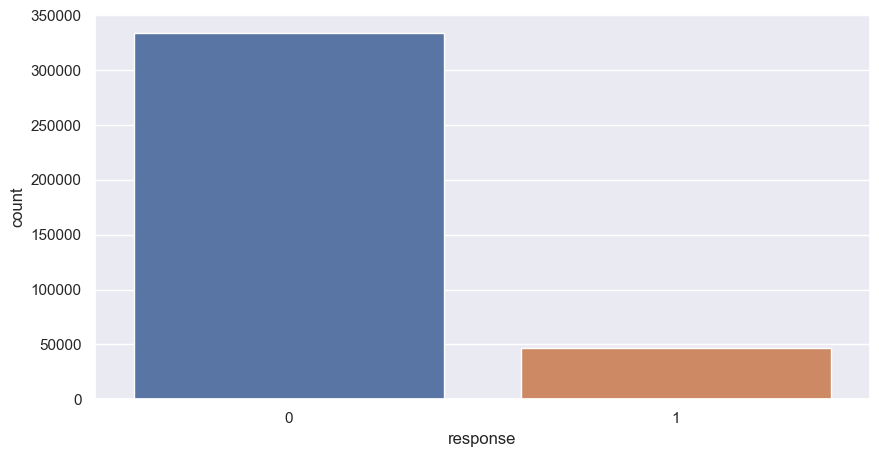

In [12]:
sns.countplot(x=df1['response'])

### 1.4.2. Categorical Attributes

In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

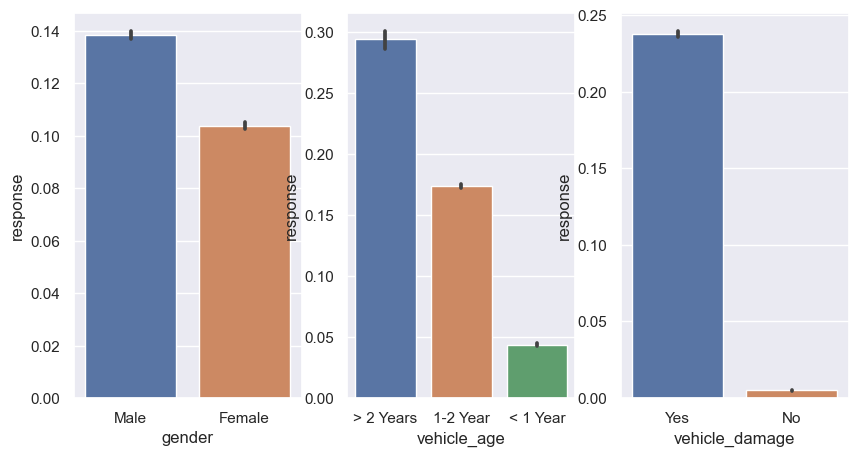

In [14]:
plt.subplot(1, 3, 1)
sns.barplot(x='gender', y='response', data=df1);

plt.subplot(1, 3, 2)
sns.barplot(x='vehicle_age', y='response', data=df1);

plt.subplot(1, 3, 3)
sns.barplot(x='vehicle_damage', y='response', data=df1);

# 2. Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                        'between_1_2_years' if x == '1-2 Year' else 'below_1_year')

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [17]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0000,0,over_2_years,1,40454.0000,26.0000,217,1
1,2,Male,76,1,3.0000,0,between_1_2_years,0,33536.0000,26.0000,183,0
2,3,Male,47,1,28.0000,0,over_2_years,1,38294.0000,26.0000,27,1
3,4,Male,21,1,11.0000,1,below_1_year,0,28619.0000,152.0000,203,0
4,5,Female,29,1,41.0000,1,below_1_year,0,27496.0000,152.0000,39,0


# 3. Data Filtering

In [18]:
df3 = df2.copy()

# 4. Exploratory Data Analysis (EDA)

In [19]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [20]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

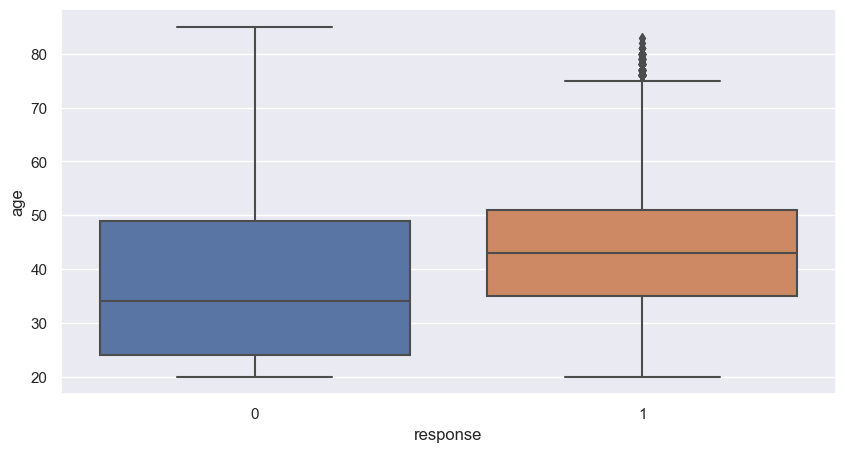

In [21]:
# age
sns.boxplot(x='response', y='age', data=df4);

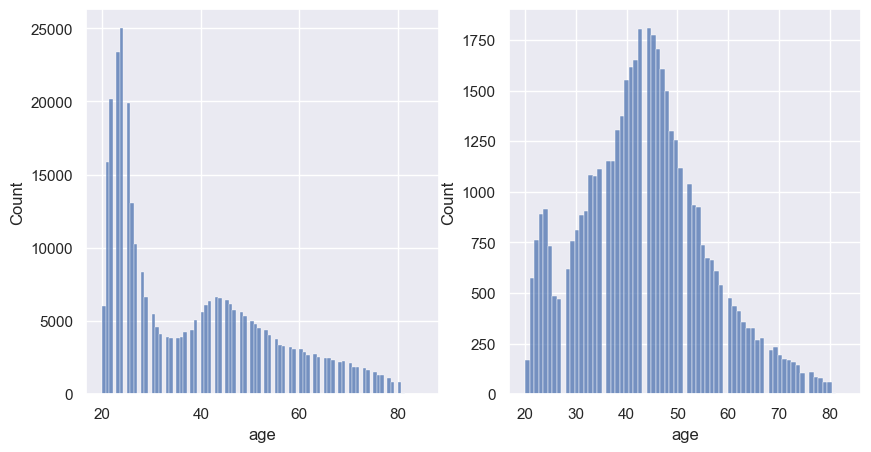

In [22]:
plt.subplot(1, 2, 1)
aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux);

plt.subplot(1, 2, 2)
aux = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux);

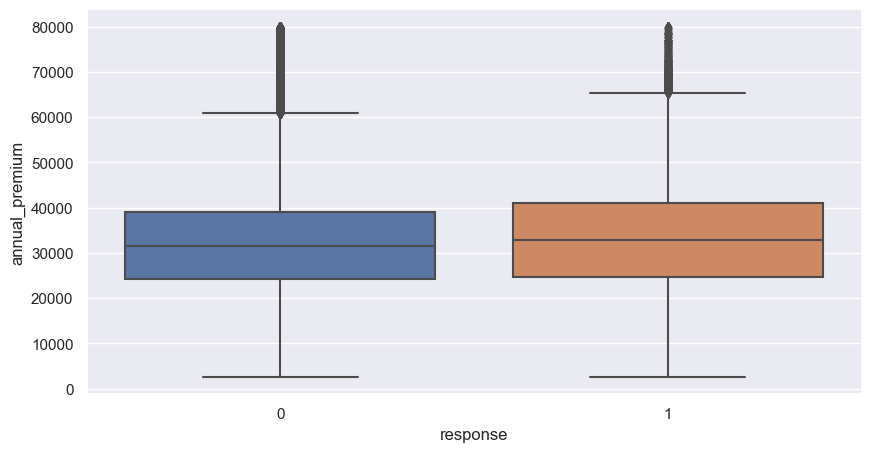

In [23]:
# annual_premmium
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux);

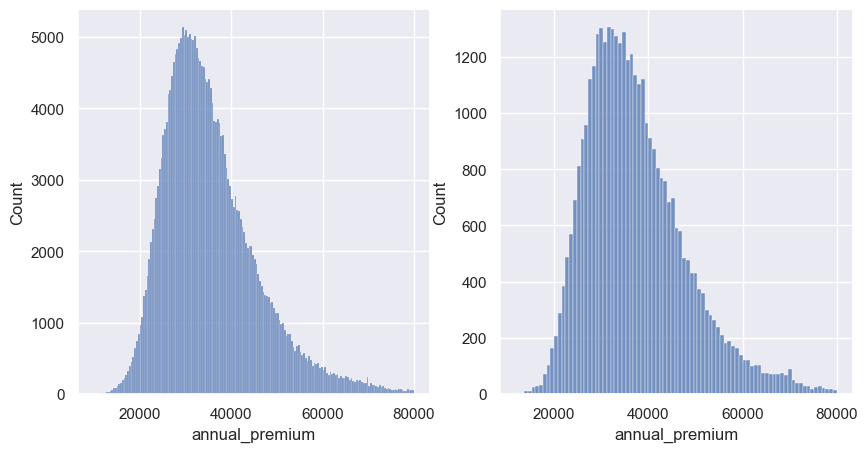

In [24]:
plt.subplot(1, 2, 1)
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux1);

plt.subplot(1, 2, 2)
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1);

In [25]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux.head()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.8773
1,1,46669,0.1227


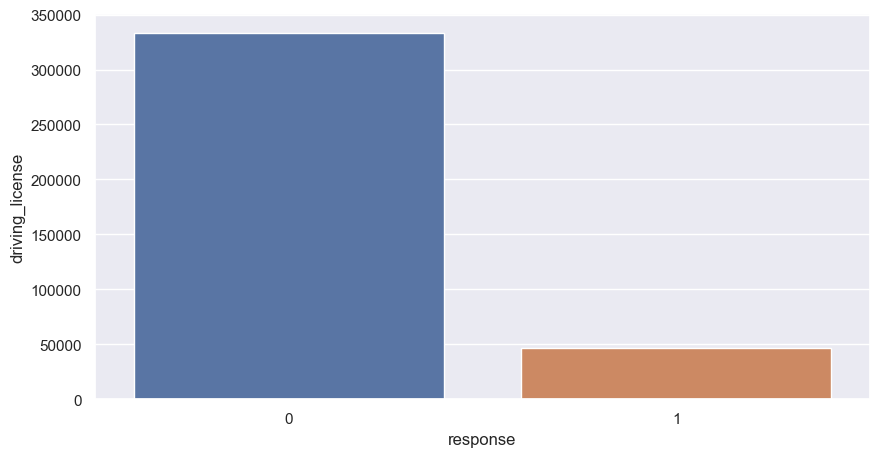

In [26]:
sns.barplot(x='response', y='driving_license', data=aux);

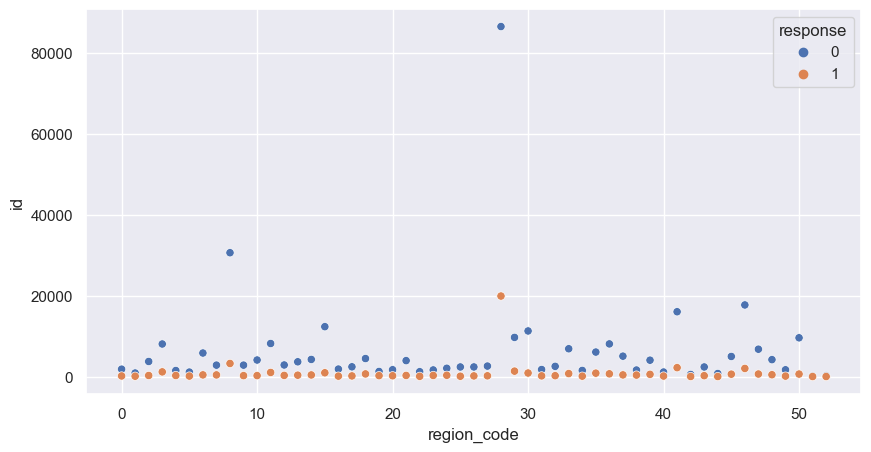

In [27]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

In [28]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.7745,0.2255
1,0.9991,0.0009


In [29]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_years,0,0.4343
1,below_1_year,0,0.4135
2,between_1_2_years,1,0.0913
3,over_2_years,0,0.0297
4,below_1_year,1,0.0189
5,over_2_years,1,0.0123


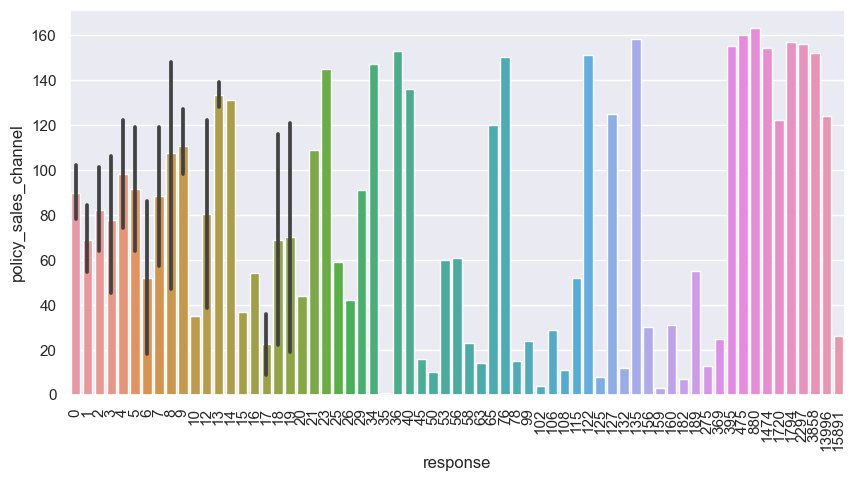

In [30]:
# policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)
plt.xticks(rotation=90);

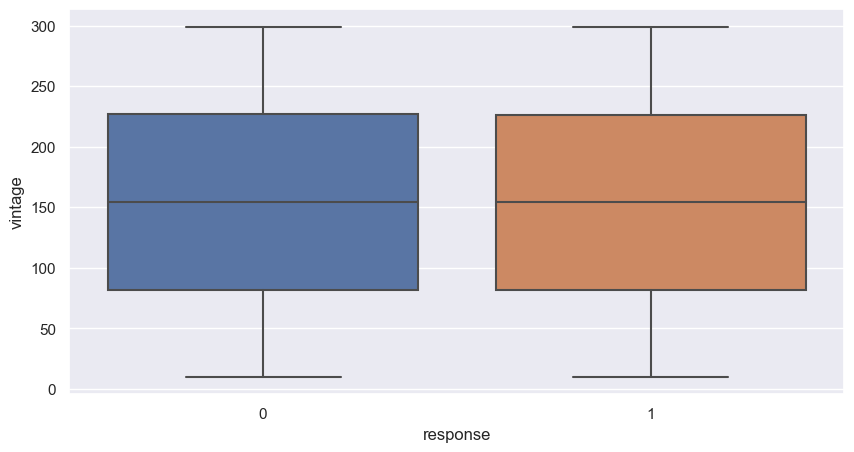

In [31]:
# vintage
sns.boxplot(x='response', y='vintage', data=df4);

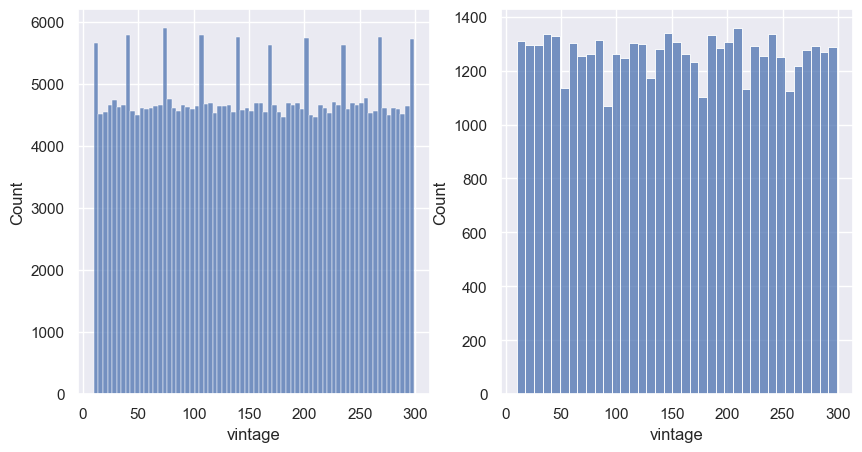

In [32]:
plt.subplot(1, 2, 1)
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux);

plt.subplot(1, 2, 2)
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux);

In [33]:
# gender
aux = df4[['id','gender', 'response']].groupby(['response', 'gender']).count().reset_index()
aux.head()

,response,gender,id
0,0,Female,156835
1,0,Male,177564
2,1,Female,18185
3,1,Male,28525


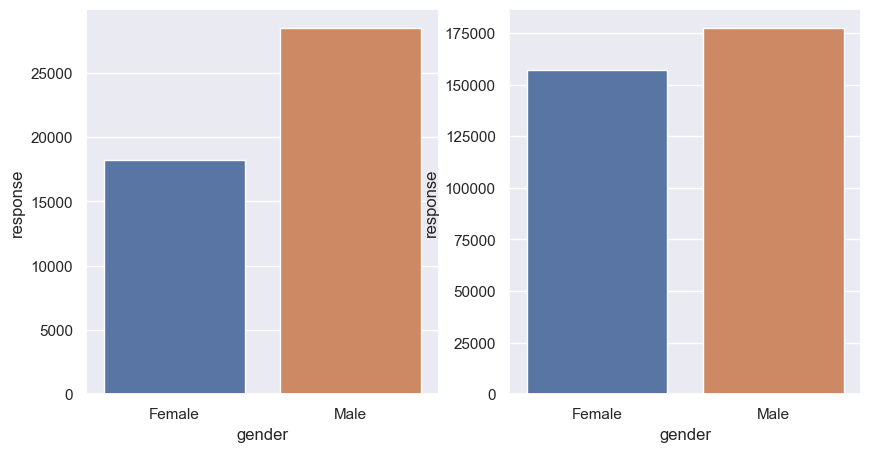

In [34]:
plt.subplot(1, 2, 1)
aux = df4[['gender', 'response']].query('response == 1').groupby('gender').count().reset_index()
sns.barplot(x='gender', y='response', data=aux);

plt.subplot(1, 2, 2)
aux = df4[['gender', 'response']].query('response == 0').groupby('gender').count().reset_index()
sns.barplot(x='gender', y='response', data=aux);

In [35]:
# vehicle_damage
aux = df4[['id','vehicle_damage', 'response']].groupby(['response', 'vehicle_damage']).count().reset_index()
aux.head()

,response,vehicle_damage,id
0,0,0,187714
1,0,1,146685
2,1,0,982
3,1,1,45728


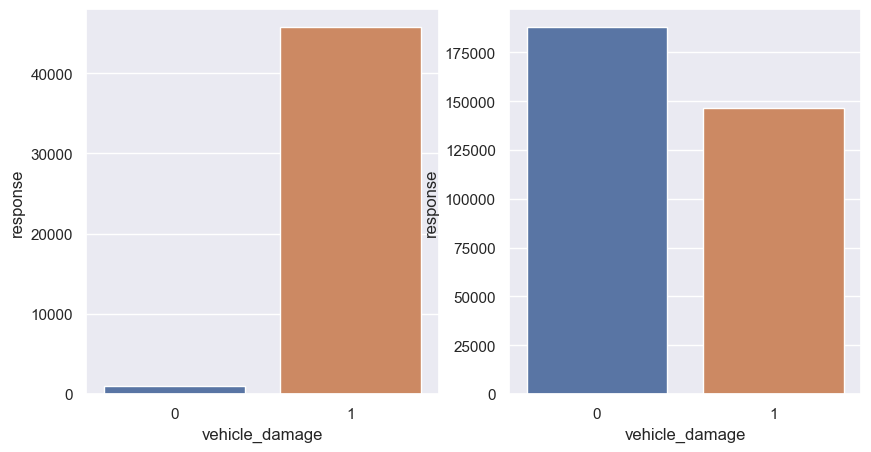

In [36]:
plt.subplot(1, 2, 1)
aux = df4[['vehicle_damage', 'response']].query('response == 1').groupby('vehicle_damage').count().reset_index()
sns.barplot(x='vehicle_damage', y='response', data=aux);

plt.subplot(1, 2, 2)
aux = df4[['vehicle_damage', 'response']].query('response == 0').groupby('vehicle_damage').count().reset_index()
sns.barplot(x='vehicle_damage', y='response', data=aux);

## 4.2. Bivariate Analysis

## 4.3. Multivariate Analysis

In [37]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 4.3.1. Numerical Variables

<AxesSubplot: >

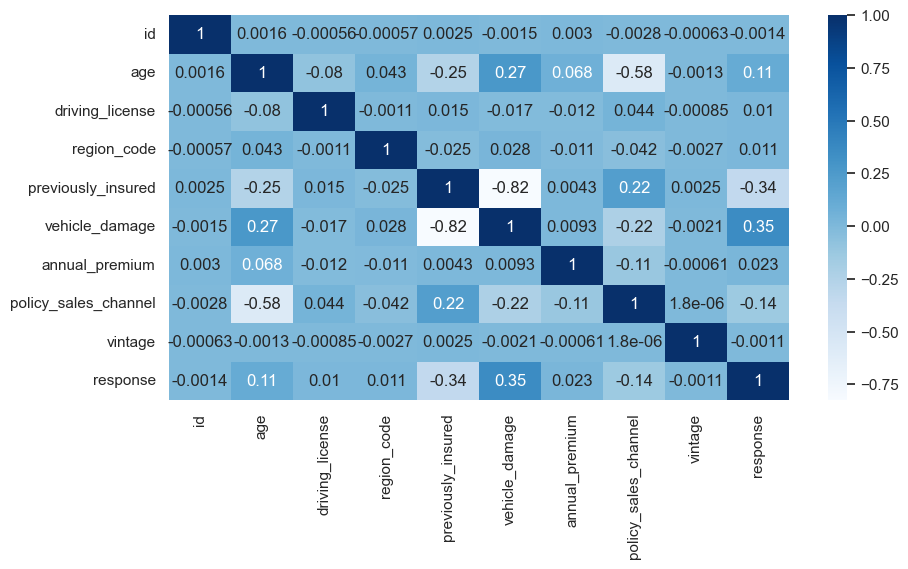

In [38]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, cmap="Blues", annot=True)

### 4.3.2. Categorical Variables

In [39]:
a = df4.select_dtypes(include='object')
a.head()

,gender,vehicle_age
0,Male,over_2_years
1,Male,between_1_2_years
2,Male,over_2_years
3,Male,below_1_year
4,Female,below_1_year


<AxesSubplot: >

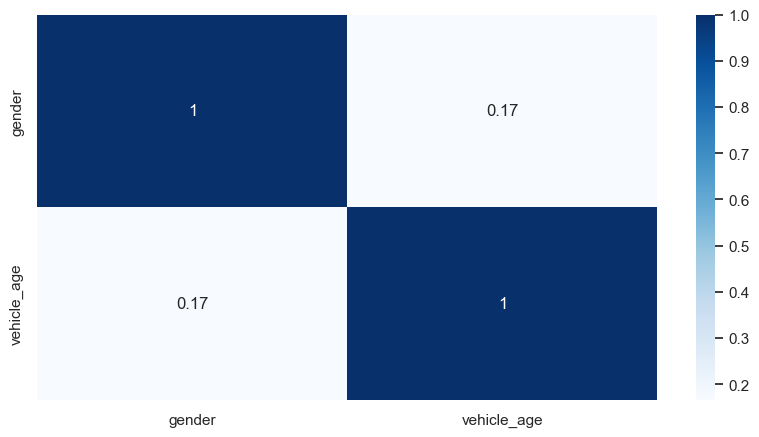

In [40]:
a = df4.select_dtypes(include='object')

a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])

a3 = cramer_v(a['vehicle_age'], a['gender'])
a4 = cramer_v(a['vehicle_age'], a['vehicle_age'])

d = pd.DataFrame({'gender':     [a1, a2],
                  'vehicle_age':[a3, a4]})

d = d.set_index(d.columns)

sns.heatmap(d, cmap="Blues", annot=True)

# 5. Data Preparation

In [41]:
df5 = df4.copy()

In [42]:
X = df5.drop('response', axis=1)
y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20)

df5=pd.concat([x_train, y_train], axis=1)

## 5.1. Standardzation

In [43]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../health_insurance_app/features/annual_premium_scaler.pkl', 'wb')) 

## 5.2. Rescaling

In [44]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../health_insurance_app/features/age_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../health_insurance_app/features/vintage_scaler.pkl', 'wb')) 

## 5.3. Encoder

In [45]:
# gender
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../health_insurance_app/features/target_encode_gender_scaler.pkl', 'wb'))

# region_code - Frequency Encoding / Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../health_insurance_app/features/target_encode_region_code_scaler.pkl', 'wb'))

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../health_insurance_app/features/fe_policy_sales_channel_scaler.pkl', 'wb')) 

C:\Users\pma2022\AppData\Local\Temp\ipykernel_33488\2203660452.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)


## 5.4. Validation Preparation

In [46]:
x_validation_data = x_validation.copy()

In [47]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

C:\Users\pma2022\AppData\Local\Temp\ipykernel_33488\2981410032.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map(target_encode_gender)


# 6. Feature Selection

In [48]:
df6 = df5.copy()

## 6.1. Boruta Feature Selection

In [49]:
x_train_n = df6.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier(n_jobs=-1)

# Define boruta
boruta = bt.BorutaPy(et, n_estimators='auto', verbose=1, random_state=42).fit(x_train_n, y_train_n )

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100


BorutaPy finished running.

Iteration: 	44 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	11


In [50]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df6.drop(['id', 'response'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

cols_selected_boruta

['age']

## 6.2. Features Importance

In [51]:
# model definition
forest = en.ExtraTreesClassifier(n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_jobs=-1)

Feature ranking:
                         feature  importance
0                        vintage      0.2746
0                 annual_premium      0.2449
0                            age      0.1614
0                    region_code      0.1075
0                 vehicle_damage      0.0694
0           policy_sales_channel      0.0600
0             previously_insured      0.0543
0       vehicle_age_below_1_year      0.0121
0  vehicle_age_between_1_2_years      0.0077
0                         gender      0.0051
0       vehicle_age_over_2_years      0.0026
0                driving_license      0.0005


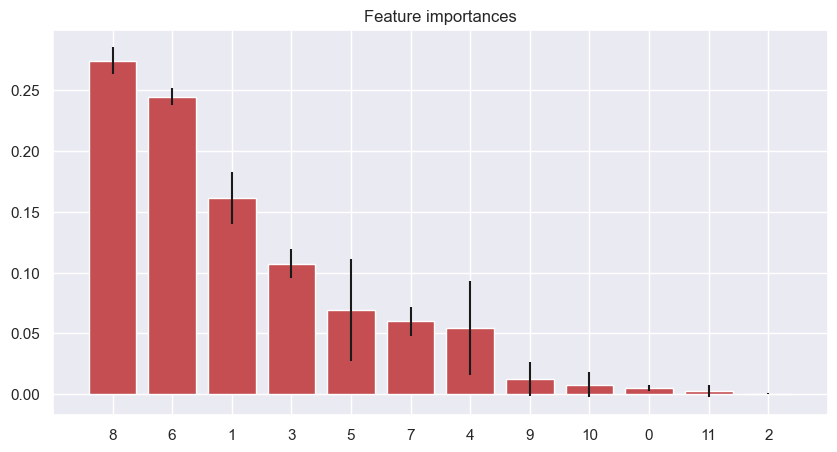

In [52]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7. Machine Learning

In [53]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df6[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1. KNN

In [54]:
# model definition
knn_model = nh.KNeighborsClassifier()

# model training
knn_model.fit(x_train, y_train)

# model prediction - generalization
yhat_knn = knn_model.predict_proba(x_val)

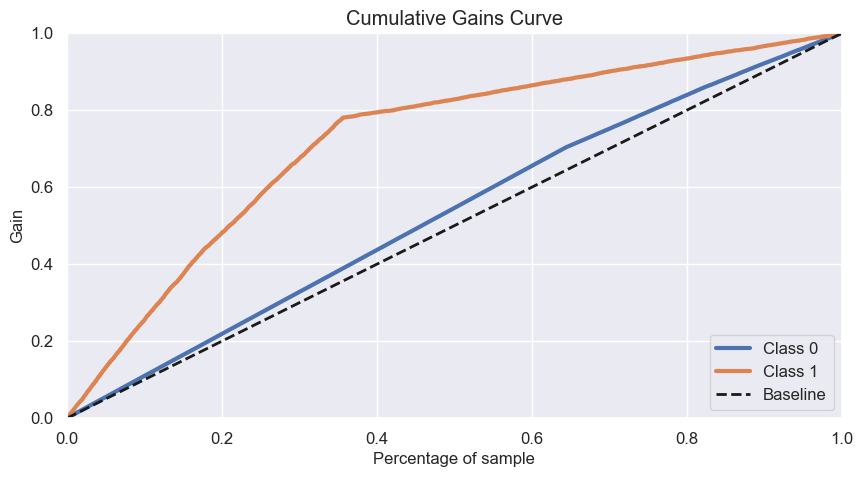

In [55]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn); 

## 7.2. Logistic Regression

In [56]:
# model definition
lr_model = lm.LogisticRegression(random_state=42) 

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

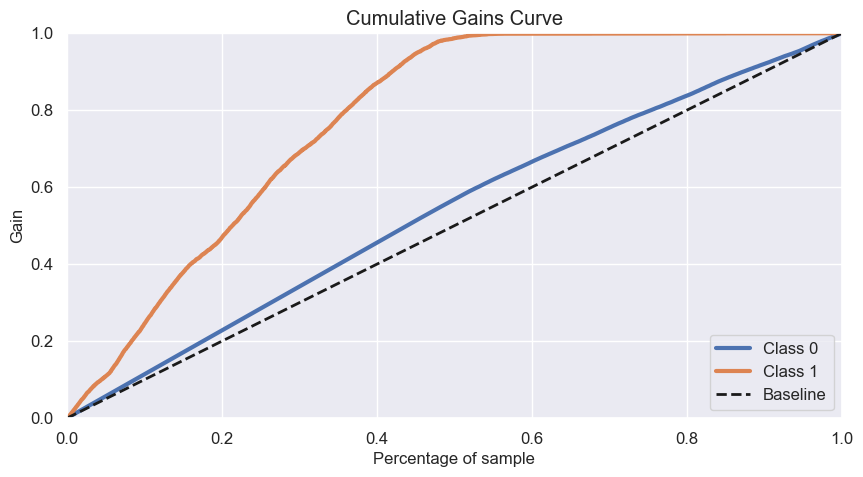

In [57]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

## 7.3. Extra Trees

In [58]:
# model definition
et = en.ExtraTreesClassifier(n_jobs=-1, random_state=42)

# model fit
et.fit(x_train, y_train)

# model predict
yhat_et = et.predict_proba(x_val)

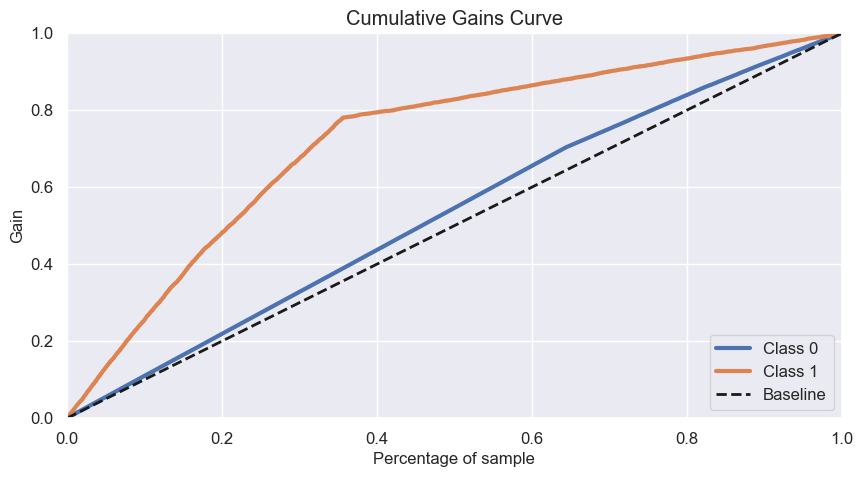

In [59]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

## 7.4. Random Forest

In [60]:
# model definition
rf = en.RandomForestClassifier(n_jobs=-1)

# model fit
rf.fit(x_train, y_train)

# model predict
yhat_rf = rf.predict_proba(x_val)

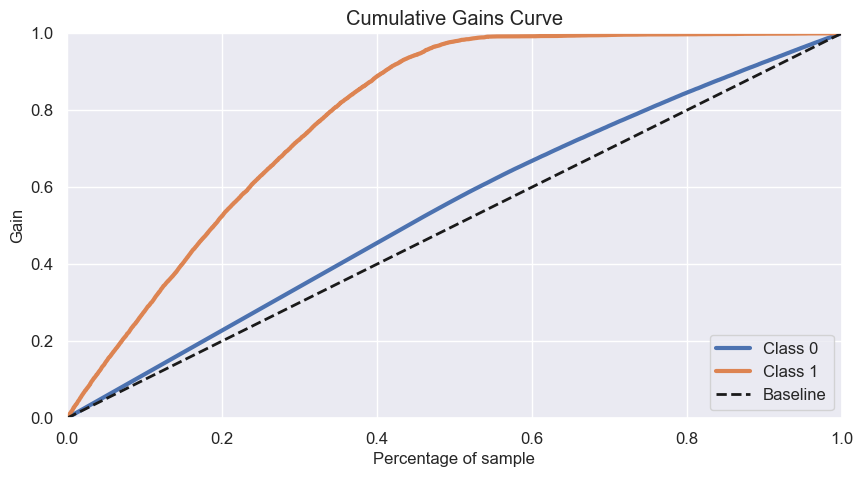

In [61]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

## 7.5. XGBoost

In [62]:
# model definition
model_xgb = xgb.XGBClassifier()

# model fit
model_xgb.fit(x_train, y_train)

# model predict
yhat_xgb = model_xgb.predict_proba(x_val)

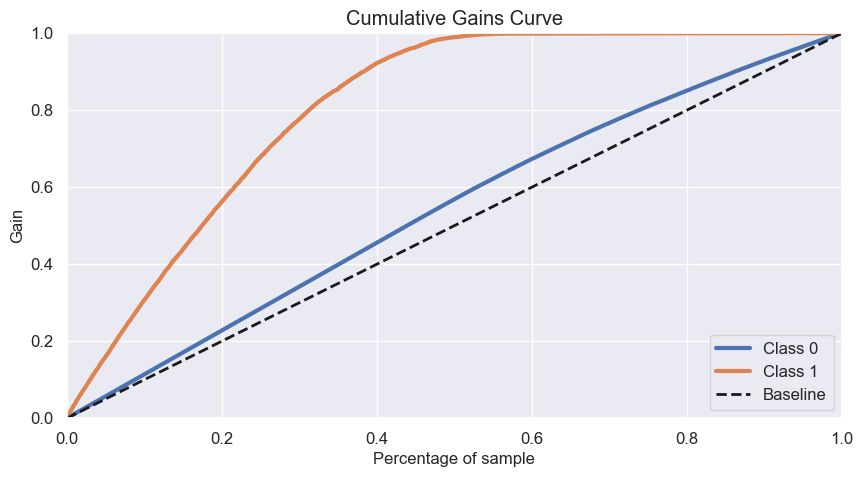

In [63]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb);

# 8. Models Performance

In [64]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

## 8.1. KNN

In [65]:
df8_knn = df8.copy()

# propensity_score
df8_knn['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df8_knn = df8_knn.sort_values('score', ascending=False)

# compute precision at k 
precision_at_2000, data = precision_at_k(df8_knn, k=2000)

# compute recall at k
recall_at_2000, data = recall_at_k(df8_knn, k=2000)

print('Precision at K: {}'.format(precision_at_2000))
print('Recall at K: {}'.format(recall_at_2000))


Precision at K: 0.32283858070964516
Recall at K: 0.06894343649946638


## 8.3. Logistic Regression

In [66]:
df8_lr = df8.copy()

# propensity_score
df8_lr['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df8_lr = df8_lr.sort_values('score', ascending=False)

# compute precision at k 
precision_at_2000, data = precision_at_k(df8_lr, k=2000)

# compute recall at k
recall_at_2000, data = recall_at_k(df8_lr, k=2000)

print('Precision at K: {}'.format(precision_at_2000))
print('Recall at K: {}'.format(recall_at_2000))

Precision at K: 0.30934532733633185
Recall at K: 0.06606189967982924


## 8.2. Extra Trees

In [67]:
df8_et = df8.copy()

# propensity_score
df8_et['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8_et = df8_et.sort_values('score', ascending=False)

# compute precision at k 
precision_at_2000, data = precision_at_k(df8_et, k=2000)

# compute recall at k
recall_at_2000, data = recall_at_k(df8_et, k=2000)

print('Precision at K: {}'.format(precision_at_2000))
print('Recall at K: {}'.format(recall_at_2000))

Precision at K: 0.344327836081959
Recall at K: 0.0735325506937033


## 8.4. Random Forest

In [68]:
df8_rf = df8.copy()

# propensity_score
df8_rf['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df8_rf = df8_rf.sort_values('score', ascending=False)

# compute precision at k 
precision_at_2000, data = precision_at_k(df8_rf, k=2000)

# compute recall at k
recall_at_2000, data = recall_at_k(df8_rf, k=2000)

print('Precision at K: {}'.format(precision_at_2000))
print('Recall at K: {}'.format(recall_at_2000))

Precision at K: 0.3658170914542729
Recall at K: 0.07812166488794023


## 8.5. XGBoost

In [69]:
df8_xgb = df8.copy()

# propensity_score
df8_xgb['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df8_xgb = df8_xgb.sort_values('score', ascending=False)

# compute precision at k 
precision_at_2000, data = precision_at_k(df8_xgb, k=2000)

# compute recall at k
recall_at_2000, data = recall_at_k(df8_xgb, k=2000)

print('Precision at K: {}'.format(precision_at_2000))
print('Recall at K: {}'.format(recall_at_2000))

Precision at K: 0.4127936031984008
Recall at K: 0.08815368196371398


# 9. Deploy to Production

In [70]:
pickle.dump(model_xgb, open('../health_insurance_app/models/model_xgb.pkl', 'wb'))

## 9.1. Health Insurance Class

In [71]:
class HealthInsurance:
    
    def __init__(self):
        self.home_path = ''
        self.annual_premium_scaler = pickle.load(open(self.home_path + '../health_insurance_app/features/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler = pickle.load(open(self.home_path + '../health_insurance_app/features/age_scaler.pkl', 'rb')) 
        self.vintage_scaler = pickle.load(open(self.home_path + '../health_insurance_app/features/vintage_scaler.pkl', 'rb')) 
        self.target_encode_gender_scaler = pickle.load(open(self.home_path + '../health_insurance_app/features/target_encode_gender_scaler.pkl', 'rb'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + '../health_insurance_app/features/target_encode_region_code_scaler.pkl', 'rb'))
        self.fe_policy_sales_channel_scaler = pickle.load(open(self.home_path + '../health_insurance_app/features/fe_policy_sales_channel_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):

        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 
    
    def feature_engineering(self, df2):

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')
        
        return df2
    
    def data_preparation(self, df5):

        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender_scaler)

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map(self.target_encode_region_code_scaler)

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        
        # model prediction
        pred = model.predict_proba(test_data)

        # join prediction into original data
        original_data['prediction'] = pred[:, 1]

        return original_data.to_json(orient='records', date_format='iso')

## 9.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response

# loading model
path = ''
model = pickle.load(open(path + '../health_insurance_app/models/model_xgb.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('127.0.0.1', debug=True)

## 9.3. API Tester

In [73]:
# loading test dataset
df_test = x_validation_data
df_test['response'] = y_validation

# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

df_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
237502,237503,Male,50,1,28.0000,1,between_1_2_years,0,26007.0000,26.0000,109,0
183939,183940,Male,24,1,50.0000,1,below_1_year,0,25081.0000,152.0000,60,0
11203,11204,Female,23,1,8.0000,0,below_1_year,1,27484.0000,152.0000,277,0
358925,358926,Male,72,1,28.0000,1,between_1_2_years,0,28312.0000,26.0000,31,0
238282,238283,Male,45,1,28.0000,0,between_1_2_years,1,36993.0000,124.0000,17,0


In [74]:
# API Call
# url = 'http://127.0.0.1:5000/predict'
url = 'https://health-insurance-app-ma.herokuapp.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [1]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('prediction', ascending=False).head()

NameError: name 'pd' is not defined